In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Retrieve and Inspect the Dataset

In [2]:
data = pd.read_excel('inclusive_features_usage.xlsx')
data.head()

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes
0,user_4737,Multilingual,60.77,4,4,Teenager,NaN,LGBTQ+
1,user_1492,Text-to-Speech,20.20,5,4,Professional,Non-Binary,NaN
2,user_5936,Colorblind Mode,93.78,2,2,Adult,Female,NaN
3,user_5519,Colorblind Mode,26.36,3,1,Adult,NaN,LGBTQ+
4,user_1853,High Contrast Mode,91.67,5,1,Young Adult,Male,NaN


In [3]:
data.dtypes

user_id                    object
feature_used               object
session_duration          float64
engagement_score            int64
accessibility_settings      int64
age_group                  object
gender                     object
additional_attributes      object
dtype: object

In [4]:
data.describe()

,session_duration,engagement_score,accessibility_settings
count,10000.000000,10000.00000,10000.000000
mean,62.443799,3.04360,2.489600
std,33.522672,1.41778,1.707332
min,5.010000,1.00000,0.000000
25%,33.070000,2.00000,1.000000
50%,63.175000,3.00000,2.000000
75%,91.600000,4.00000,4.000000
max,120.000000,5.00000,5.000000


# Data Cleaning and Preparation

## Missing Values: 

In [5]:
for x in data.columns:
    print(f'There are {data[x].isna().sum()} missing values in the column {x}.')

There are 0 missing values in the column user_id.
There are 0 missing values in the column feature_used.
There are 0 missing values in the column session_duration.
There are 0 missing values in the column engagement_score.
There are 0 missing values in the column accessibility_settings.
There are 0 missing values in the column age_group.
There are 3997 missing values in the column gender.
There are 6003 missing values in the column additional_attributes.


For the original gender and additional_attributes columns, I filled missing values as an `'Unknown'` string. Dropping rows with missing values would not be feasible since a sizable percentage of the records in the dataset have a missing value in either column, and filling the missing values with a "0" string can be confusing -- for gender, 0 could be interpreted as none of the above, or something else. 

In [6]:
data['gender'] = data['gender'].fillna('Unknown').astype('object')
data['additional_attributes'] = data['additional_attributes'].fillna('Unknown').astype('object')

## Outliers

For session duration, there are no points that lie further than 1.5 times the IQR from the median. Also, there are also no points that lie outside a z-score of 2 from the mean. The box plot indicates a uniform distrubtion, though the histogram shows some variation in the frequency of the scores (in bins of 20). Still, there do not appear to be any outliers. 


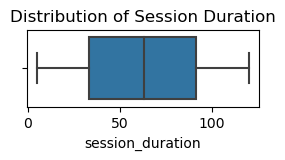

In [7]:
plt.figure(figsize=(3, 1))
plt.title('Distribution of Session Duration')
sns.boxplot(x = data['session_duration'])
plt.show()

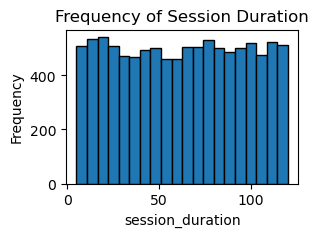

In [8]:
plt.figure(figsize=(3, 2))  
plt.title('Frequency of Session Duration')
plt.hist(
    data['session_duration'], 
    bins=20, 
    edgecolor='black'
)
plt.xlabel('session_duration')
plt.ylabel('Frequency')
plt.show()

In [9]:
# shows rows that have a session duration further than 1.5*IQR away from median duration
# there are none
q1 = data['session_duration'].quantile(.25)
q3 = data['session_duration'].quantile(.75)
iqr = q3 - q1
low_bound = q1 - (iqr*1.5)
up_bound = q3 + (iqr*1.5)
data[(data['session_duration']<low_bound) | (data['session_duration']>up_bound)]

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes


In [10]:
# shows rows that have a z-score greater than 2
# there are none
mean = data['session_duration'].mean()
std = data['session_duration'].std()
data['z-score']=(data['session_duration']-mean)/std
data[(data['z-score']<-2) | (data['z-score']>2)]

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,z-score


There do not appear to be outliers in engagement scores. The histogram shows that the frequency of each score is pretty even across the board. There are no points that lie further than 1.5 times the IQR from the median. There are also no points that lie outside a z-score of 2 from the mean. 

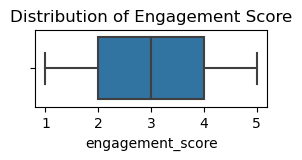

In [11]:
plt.figure(figsize=(3, 1))
plt.title('Distribution of Engagement Score')
sns.boxplot(x = data['engagement_score'])
plt.show()

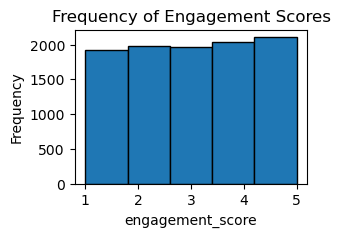

In [12]:
plt.figure(figsize=(3, 2))  
plt.hist(
    data['engagement_score'], 
    bins=5, 
    edgecolor='black'
)
plt.xlabel('engagement_score')
plt.ylabel('Frequency')
plt.title('Frequency of Engagement Scores')
plt.show()

In [13]:
# shows rows that have an engagement score further than 1.5*IQR away from median score
# there are none
q1 = data['engagement_score'].quantile(.25)
q3 = data['engagement_score'].quantile(.75)
iqr = q3 - q1
low_bound = q1 - (iqr*1.5)
up_bound = q3 + (iqr*1.5)
data[(data['engagement_score']<low_bound) | (data['engagement_score']>up_bound)]

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,z-score


In [14]:
# shows rows that have a z-score greater than 2
# there are none
mean = data['engagement_score'].mean()
std = data['engagement_score'].std()
data['z-score']=(data['engagement_score']-mean)/std
data[(data['z-score']<-2) | (data['z-score']>2)]

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,z-score


## High Accessibility User Classification: 
Explain your choice and its implications for model interpretability.

In [15]:
data['high_accessibility_user'] = [1 if x>=3 else 0 for x in data['accessibility_settings']]

## Intersectionality Analysis

I realized during EDA (see heatmap) that the data points only *either* include gender or additional attribute -- for instance, a person who is Teenage and Female could not also be marked as LGBTQ+ or Person of Color. 

So I simplified the intersectionality column to have only two categories (age_group and either gender or additional attribute (whichever was not missing), and called this column `Demographic`.

Since there were no data points with intersection between gender and LGBTQ/POC in the first place, I opted for easier-to-understand visualizations, although this would not be the case when working with real-world data.

In [16]:
data['Demographic']=data['age_group'] + ' - ' + \
    np.where(
        data['gender']!='Unknown', 
        data['gender'], 
        data['additional_attributes']
    )

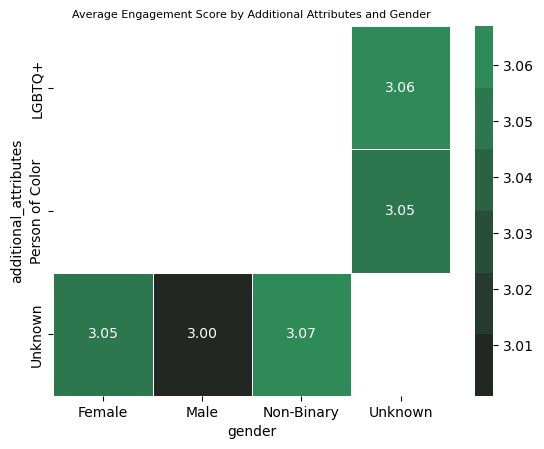

In [17]:
# people in dataset either have a gender or an additional attribute
dark_green = sns.dark_palette('seagreen')

sns.heatmap(
    data = data.groupby(['additional_attributes', 'gender'])['engagement_score'].mean().unstack(),
    cmap = dark_green,
    annot = True, fmt = '.2f',
    linewidths = 0.5,
)
plt.title('Average Engagement Score by Additional Attributes and Gender', fontsize=8)
plt.show()

In [18]:
# shows rows that have something in both columns (gender and additional attributes)
# there are none
data[(data['gender']!='Unknown')&(data['additional_attributes']!='Unknown')]

,user_id,feature_used,session_duration,engagement_score,accessibility_settings,age_group,gender,additional_attributes,z-score,high_accessibility_user,Demographic


# EDA

## Engagement Score Analysis
For the multilingual feature, the demographics with the highest engagement are LGBTQ+ and professionals. For text-to-speech, there isn't much variation between genders and additional attributes, but teenagers, young adults, and professionals have much higher engagement than adults and seniors. Professionals and seniors have the highest engagement for colorblind mode, professionals have the highest engagement for high contrast mode, and teenagers and seniors have the highest engagement for visual aid. 

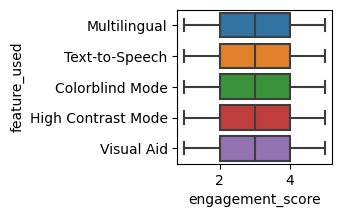

In [19]:
# engagement scores uniformly distributed across features used
plt.figure(figsize=(2, 2))

sns.boxplot(x = data['engagement_score'], y = data['feature_used'])
plt.show()

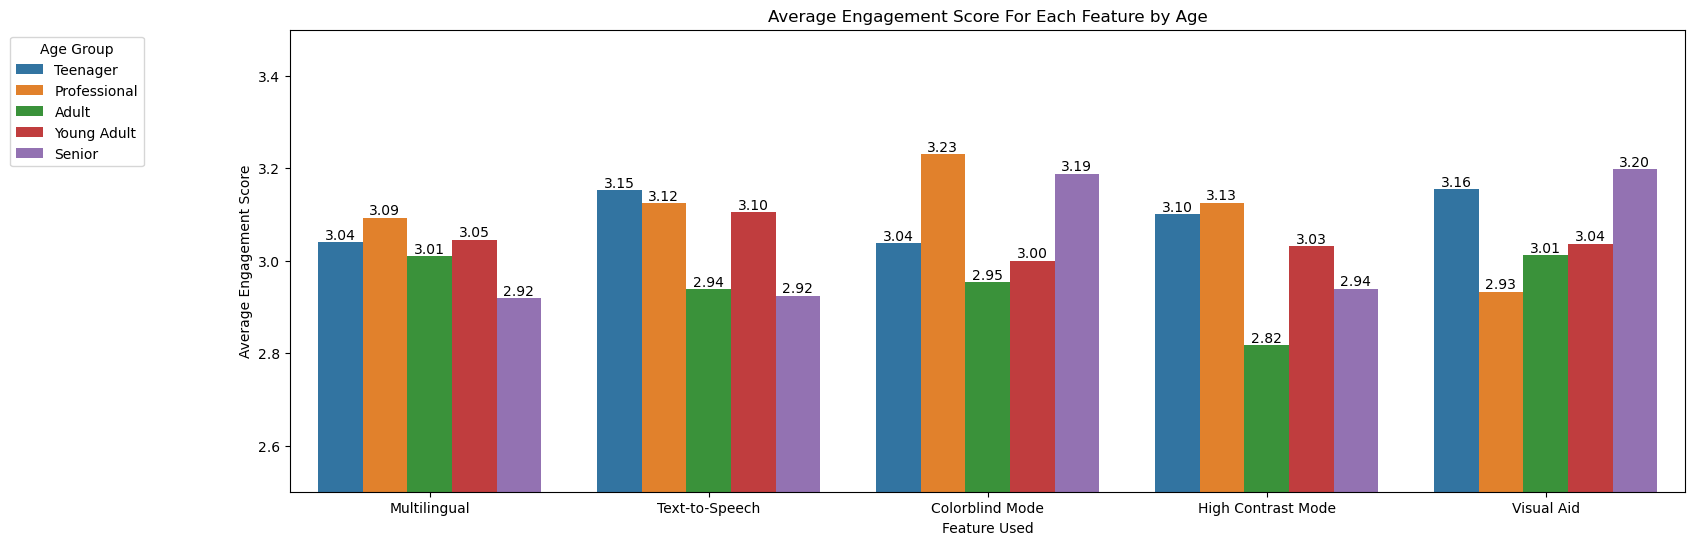

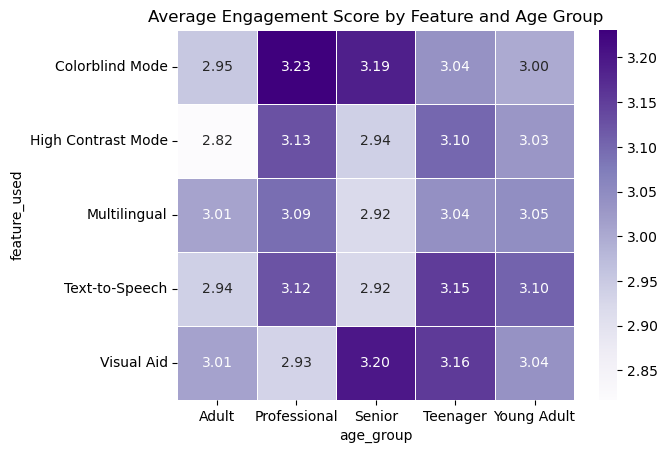

In [20]:
plt.figure(figsize=(18, 6))  
sns.barplot(
    data = data, 
    x = data['feature_used'],
    y = data['engagement_score'],
    hue = data['age_group'],
    ci = None
)
plt.title("Average Engagement Score For Each Feature by Age")
plt.xlabel("Feature Used")
plt.ylabel("Average Engagement Score")
plt.legend(title='Age Group', bbox_to_anchor=(-.1, 1), loc='upper right')
plt.ylim(2.5, 3.5) 
ax = plt.gca()
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
plt.show()


sns.heatmap(
    data = data.groupby(['feature_used', 'age_group'])['engagement_score'].mean().unstack(),
    cmap = 'Purples',
    annot = True, fmt = '.2f',
    linewidths = 0.5,
)
plt.title('Average Engagement Score by Feature and Age Group')
plt.show()

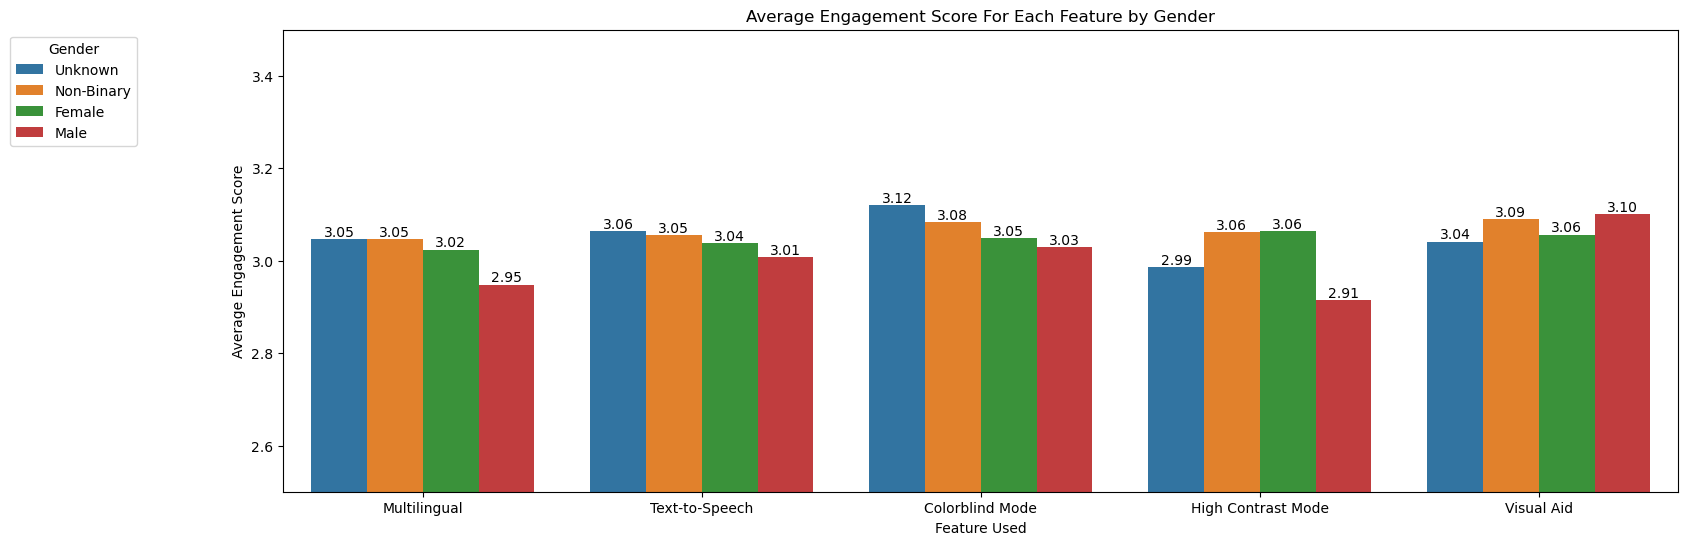

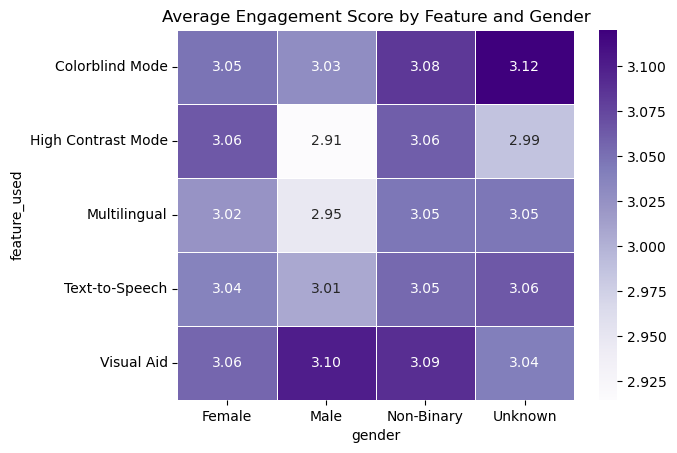

In [21]:
plt.figure(figsize=(18, 6))  

sns.barplot(
    data = data, 
    x = data['feature_used'],
    y = data['engagement_score'],
    hue = data['gender'],
    ci = None
)

plt.title("Average Engagement Score For Each Feature by Gender")
plt.xlabel("Feature Used")
plt.ylabel("Average Engagement Score")
plt.legend(title='Gender', bbox_to_anchor=(-.1, 1), loc='upper right')
plt.ylim(2.5, 3.5) 
ax = plt.gca()
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
plt.show()    

sns.heatmap(
    data = data.groupby(['feature_used', 'gender'])['engagement_score'].mean().unstack(),
    cmap = 'Purples',
    annot = True, fmt = '.2f',
    linewidths = 0.5,
)
plt.title('Average Engagement Score by Feature and Gender')
plt.show()

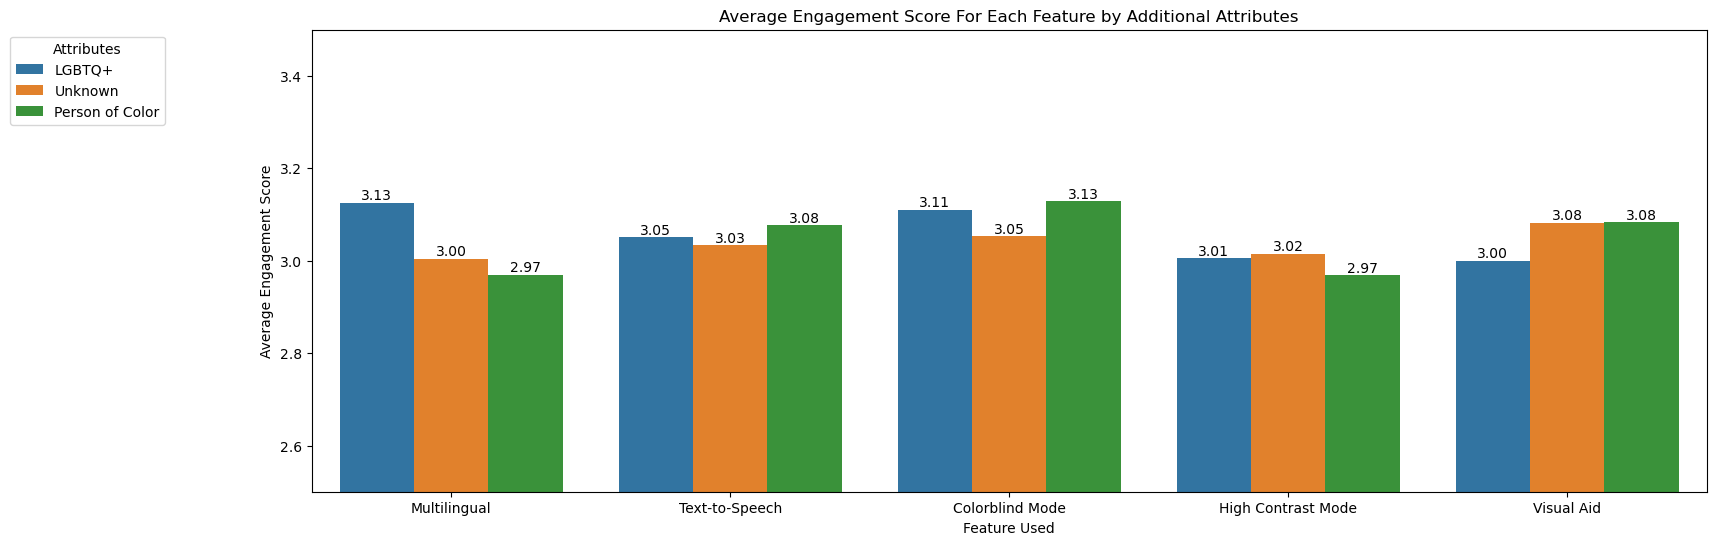

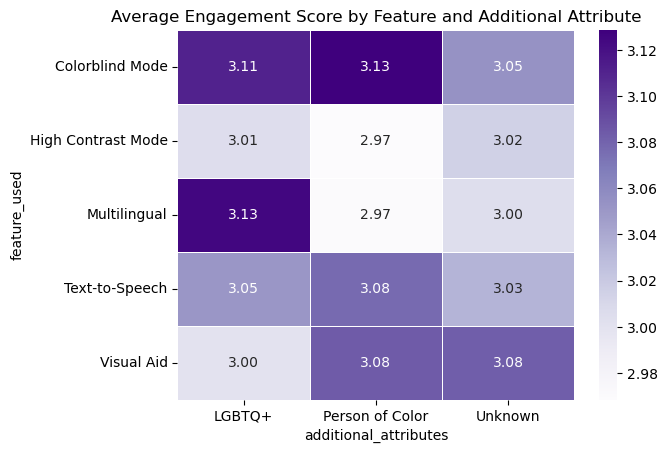

In [22]:
plt.figure(figsize=(18, 6))  

sns.barplot(
    data = data, 
    x = data['feature_used'],
    y = data['engagement_score'],
    hue = data['additional_attributes'],
    ci = None
)

plt.title("Average Engagement Score For Each Feature by Additional Attributes")
plt.xlabel("Feature Used")
plt.ylabel("Average Engagement Score")
plt.legend(title='Attributes', bbox_to_anchor=(-.1, 1), loc='upper right')
plt.ylim(2.5, 3.5) 
ax = plt.gca()
for p in ax.patches:
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
plt.show()    

sns.heatmap(
    data = data.groupby(['feature_used', 'additional_attributes'])['engagement_score'].mean().unstack(),
    cmap = 'Purples',
    annot = True, fmt = '.2f',
    linewidths = 0.5,
)
plt.title('Average Engagement Score by Feature and Additional Attribute')
plt.show()

## Feature Usage by Demographic

In [23]:
grouped_data_means =  (
    data.groupby(['Demographic', 'feature_used'])
    .mean()
    .reset_index()
)

People in similar age groups tend to have similar engagement scores across all features. In the Average Engagement Score heatmap below, you can see professionals have very similar rows, and so do young adult and teenagers.

         Average Engagement Score by Feature Used and Demographic


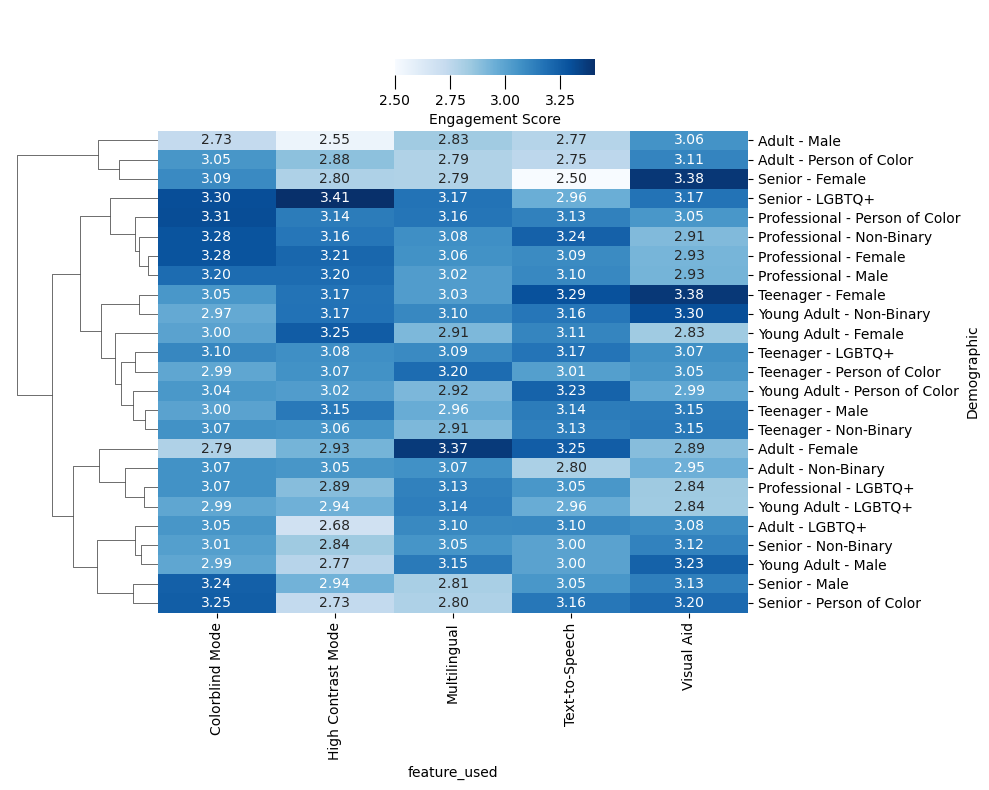

In [24]:
pivot_data = grouped_data_means.pivot(
    index='Demographic', 
    columns='feature_used', 
    values='engagement_score'
).fillna(0)

clustermap = sns.clustermap(
    pivot_data,
    col_cluster=False,
    cmap='Blues', 
    method='ward', 
    annot=True, 
    fmt='.2f', 
    figsize=(10, 8),
    cbar_kws={'orientation':'horizontal', 'label':'Engagement Score'}
)
print('         Average Engagement Score by Feature Used and Demographic')
clustermap.ax_cbar.set_position([.4, .9, .2, 0.02])
clustermap.ax_cbar.tick_params(axis='x', length=10)
plt.show()

Looking at session duration (below), we can see that seniors and men across all age groups have on average long sessions using the colorblind mode. 

Notably, the demographic with the longest average session is teenaged girls, and nonbinary adults and adults of color have similar lession lengths across the features.

         Average Session Duration by Feature Used and Demographic


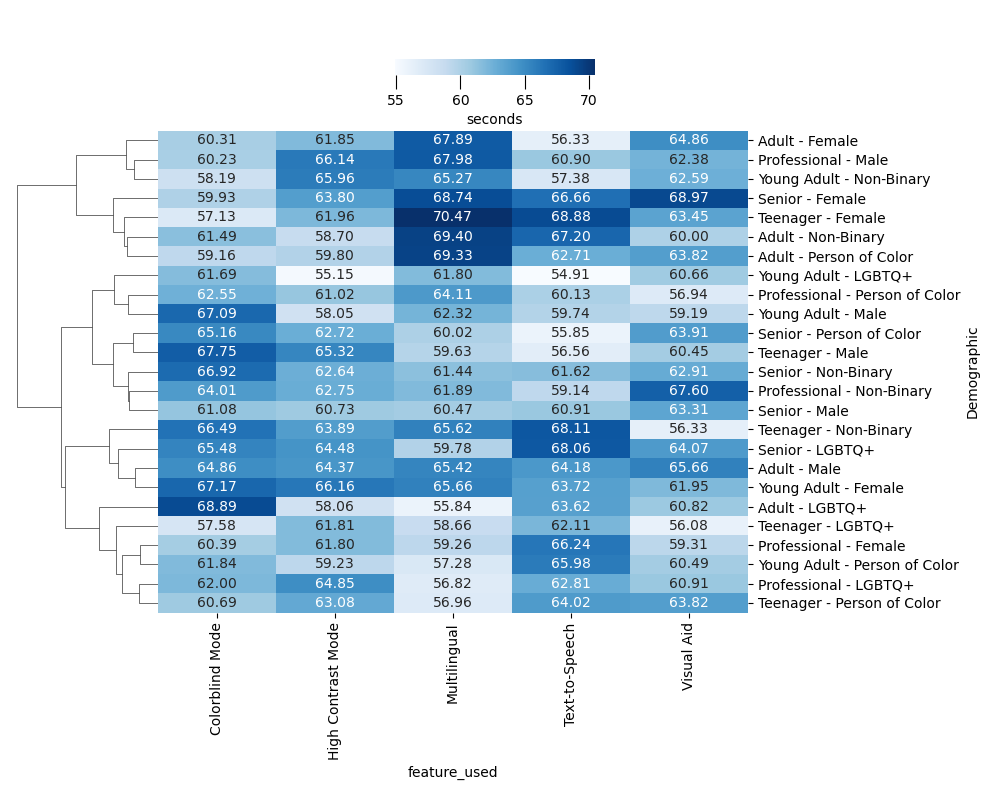

In [25]:
pivot_data = grouped_data_means.pivot(
    index='Demographic', 
    columns='feature_used', 
    values='session_duration'
).fillna(0)

clustermap = sns.clustermap(
    pivot_data,
    cmap='Blues', 
    method='ward', 
    annot=True, 
    fmt='.2f', 
    figsize=(10, 8),
    cbar_kws={'orientation':'horizontal', 'label':'seconds'},
    col_cluster=False
)
print('         Average Session Duration by Feature Used and Demographic')
clustermap.ax_cbar.set_position([.4, .9, .2, 0.02])
clustermap.ax_cbar.tick_params(axis='x', length=10)
plt.show()

Below, we see that the group with the most accessibility settings enabled is adult women using the colorblind mode, with an average of 3.09 settings enabled. Adult and teenaged people of color also have a high average number of accessibility settings enabled at 2.97.

 Average Number of Accessibility Settings Enabled by Feature Used and Demographic


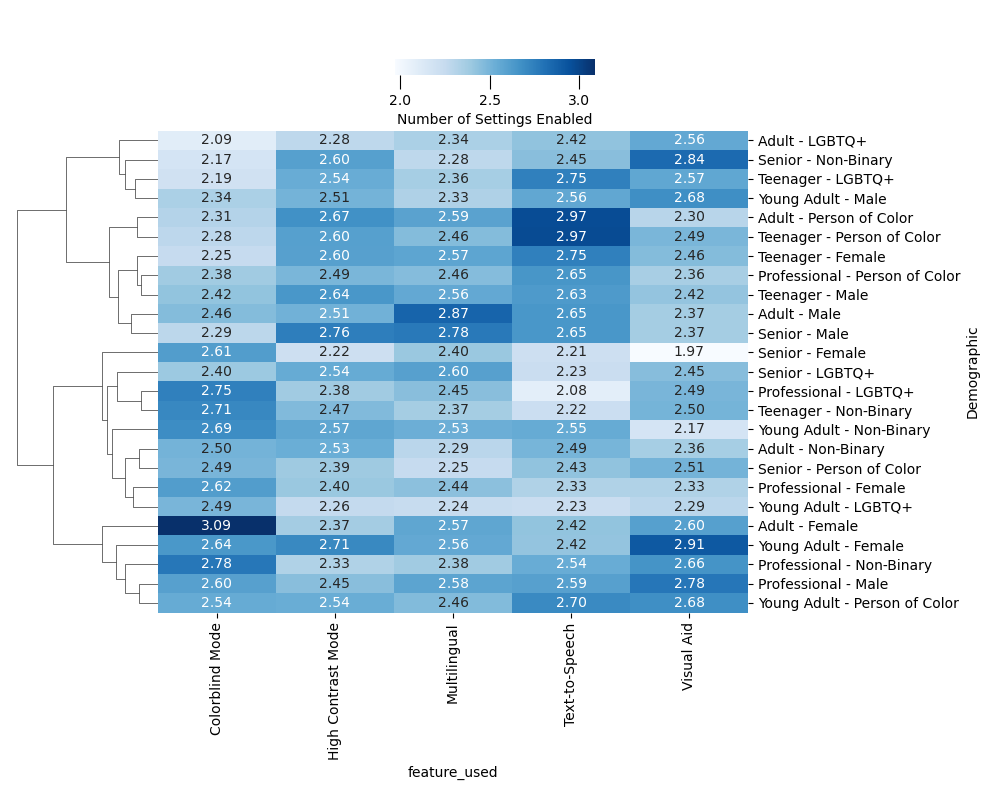

In [26]:
pivot_data = grouped_data_means.pivot(
    index='Demographic', 
    columns='feature_used', 
    values='accessibility_settings'
).fillna(0)

clustermap = sns.clustermap(
    pivot_data,
    col_cluster=False,
    cmap='Blues', 
    method='ward', 
    annot=True, 
    fmt='.2f', 
    figsize=(10, 8),
    cbar_kws={'orientation':'horizontal', 'label':'Number of Settings Enabled'}
)
print(' Average Number of Accessibility Settings Enabled by Feature Used and Demographic')
clustermap.ax_cbar.set_position([.4, .9, .2, 0.02])
clustermap.ax_cbar.tick_params(axis='x', length=10)
plt.show()

# Feature Engineering and Predictive Modeling

## New Features

In [27]:
data['avg_session_duration_for_feature'] = data.groupby('feature_used')['session_duration'].transform('mean')
data['avg_engagement_score_for_demographic'] = data.groupby('Demographic')['engagement_score'].transform('mean')
data['avg_engagement_score_for_accessibility_settings'] = data.groupby('accessibility_settings')['engagement_score'].transform('mean')

## Predictive Model

In [29]:
variables = [
    'age_group',
    'Demographic', 
]
one_hot_encodings = pd.get_dummies(data[variables], columns=variables)
X_train, X_test, y_train, y_test = train_test_split(one_hot_encodings, data['high_accessibility_user'])

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree.score(X_test,y_test)

0.516

# Insights and Recommendations